<a href="https://colab.research.google.com/github/svarunid/Dog-Breed-Identification-using-TfHub-Model/blob/main/dog_breed_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶 Dog Breed Identification

A work to classify the images of dogs based on their breed using transfer learning (model from TensorflowHub). 

## Problem

Given, images of dogs, try to predict the probability of it belonging to a certain breed.


## Data

The dataset from https://www.kaggle.com/c/dog-breed-identification/data
contains image of dogs separated into train and test sets. The training sets 'Has labels' while the test set 'Has no labels'.

## Evaluation

For each image in the test set, predict a probability for each of the different breeds.

The evaluation will be made based on **Multi Class Log Loss** between 'Predicted probs' and 'Observed labels'.

# Data Loading

In [ ]:
# unzip data
# !unzip "drive/MyDrive/Data/dog-breed-identification.zip" -d "drive/MyDrive/Colab Notebooks/Dog Breed Identification"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

print(tf.__version__)
print(hub.__version__)

2.6.0
0.12.0


In [ ]:
import pandas as pd

# import our labels
labels = pd.read_csv("drive/MyDrive/Colab Notebooks/Dog Breed Identification/labels.csv")
len(labels)

10222

In [ ]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


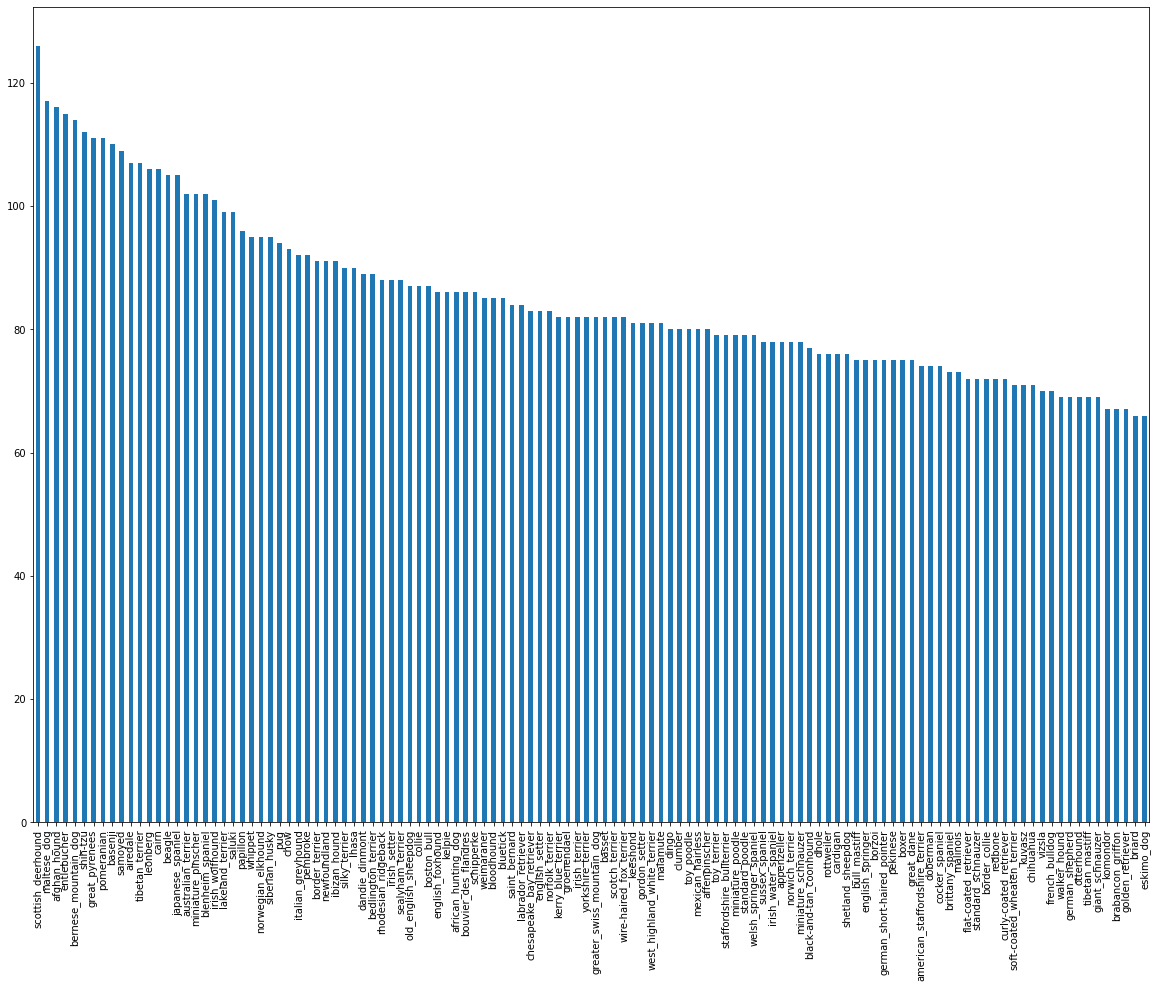

In [ ]:
labels["breed"].value_counts().plot.bar(figsize=(20,15))

In [ ]:
import os

# Check whether the training images and labels are equal in number
print(len(os.listdir("drive/MyDrive/Colab Notebooks/Dog Breed Identification/train")) == len(labels))

True


In [ ]:
# Convert IDs to a list of path to images
filenames = ["drive/MyDrive/Colab Notebooks/Dog Breed Identification/train/" + fname + ".jpg" for fname in labels["id"]]
filenames[:5]

['drive/MyDrive/Colab Notebooks/Dog Breed Identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Breed Identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Breed Identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Breed Identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Breed Identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [ ]:
# Convert the dog breeds into a separate array
labels = labels["breed"].to_numpy()

In [ ]:
import numpy as np

# Get Unique Breeds
breeds = np.unique(labels)
len(breeds)

120

In [ ]:
boolean_labels = [breeds == label for label in labels]
len(boolean_labels)

10222

# Split Data

To reduce the amount of time with experimentation, work with a subset of images.

In [ ]:
NUM_IMG = 1000 # @param{type:"slider",max:10000,min:1000,step:1000}

In [ ]:
X = filenames
y = boolean_labels

In [ ]:
from sklearn.model_selection import train_test_split

np.random.seed(0)

# Split data itno train and valid sets
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMG],
                                                  y[:NUM_IMG],
                                                  test_size=0.2)

# Preprocessing

A function that transform images into tensors.

1. Takes an image filename as input.
2. Uses TensorFlow to read the file and save it to a variable.
3. Turn our image (a jpeg file) into Tensors.
4. Normalize the tensors from ranging between 0-255 to betwwen 0-1.
4. Resize the image to be of shape (224, 224).
5. Return the modified image.

In [ ]:
# The size to which the image has to be resized
IMG_SIZE = 224

def img_to_tensor(img_path,img_size=IMG_SIZE):
  """
  Fetches the image from the file path, turns it into tensors
  and scale them to the size specified.
  """
  # Fetch the image from the img_path path
  image = tf.io.read_file(img_path)
  # Covert the image to tensors of 3 channel
  image = tf.image.decode_jpeg(image, channels=3)
  # Normalize the tensor to have values ranging from 0(0) to 1(255)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to the given size
  image = tf.image.resize(image, size=[img_size,img_size])

  return image

 # Batching
 Turn the the data into tuples (image, label) and separate them into minbatches.


In [ ]:
# The size to each batch
BATCH_SIZE = 32

def get_img_label(img_path, label):
  """
  Takes an img_path as input, processes it and returns a tuple (image, label).
  """
  image = img_to_tensor(img_path)
  return image, label

def create_batch(X, y=None, batch_size=BATCH_SIZE, test_data=False, valid_data=False):
  """
  Create a data batch of size same as batch_size.

  Shuffle data if it's training set and do not shuffle validation data. 
  Also accepts test data as input.
  """
  if test_data:
    print("Processing test data..")
    # Create a dataset from the data.
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    # Separate them into batches.
    data_batch = data.map(img_to_tensor).batch(batch_size)
  
  if valid_data:
    print("Processing validation data..")
    # Do not shuffle the data
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data_batch = data.map(get_img_label).batch(batch_size)

  if not test_data and not valid_data:
    print("Processing training data..")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffle the Data
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(get_img_label).batch(batch_size)

  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_batch(X_train, y_train)
val_data = create_batch(X_val, y_val, valid_data=True)

Processing training data..
Processing validation data..


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

# Visualization

Visualizing the a sample of images with their labels.

In [ ]:
import matplotlib.pyplot as plt

def display_img(images, labels):
  """
  Display a sample of 25 images with labels from the first batch.
  """
  # Create a figure
  plt.figure(figsize=(15,10))
  for i in range(25):
    # Define plots one by one starting from left to right
    ax = plt.subplot(5,5,i+1)
    # Display the image
    plt.imshow(images[i])
    # Display the dog breed
    plt.title(breeds[labels[i].argmax()])
    # Turn the axis line off
    plt.axis("off")

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())

# display_img(train_images, train_labels)

# Creating a Model

Setup the EfficientNet model from TfHub, compile and build the model.



In [ ]:
# Setup Input Size
INPUT_SHAPE = (None, IMG_SIZE, IMG_SIZE, 3)

# Seutp output size
OUTPUT_SIZE = len(breeds)

# Choosen model from tfHub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


In [ ]:
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SIZE,url=MODEL_URL):
  """
  Create, compile and build a model from tfHub.
  """
  print("Building model", url)
  
  model = tf.keras.Sequential([
    hub.KerasLayer(url),
    tf.keras.layers.Dense(units=output_shape,
                          activation="softmax")
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["Accuracy"]
  )

  # Build model
  model.build(
      input_shape
  )

  return model

In [ ]:
# model = create_model()
# model.summary()

# Setup Callbacks

- Create TensorBoard callback funtion to save the log
- Setup a early stopping callback to prevent the model from overfitting

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# TensorBoard Callback
def tensorboard_callback():
  # Setup a directory to store the logs
  logdir = os.path.join("drive/MyDrive/Colab Notebooks/Dog Breed Identification/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
# Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_Accuracy",
                                                  mode="max",
                                                  patience=1)

# Train Model

Initialize a model and fit the data to the model.

In [ ]:
NUM_EPOCHS = 50 #@param {type:"slider",min:10,max:100,step:5}

In [ ]:
def train_model():
  """
  Initialize a model and fit the data to the model
  """
  model = create_model()

  tensorboard = tensorboard_callback()

  model.fit(x=train_data,
            validation_data=val_data,
            epochs=NUM_EPOCHS,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping]
  )

  return model

In [ ]:
# model = train_model()

### Checking TensorBoard Logs


In [ ]:
# %tensorboard --logdir drive/MyDrive/Colab\ Notebooks/Dog\ Breed\ Identification/logs

# Making Predictions

Test the trained model by making some prediction on the validation images

In [ ]:
# predictions = model.predict(val_data)
# predictions.shape

In [ ]:
# predictions[0]

# Visualizing Predicitons
Visualize the the prediciton and evaluted the model

In [ ]:
def unbatch_data(data):
  """
  Unbatch the given data.

  Returns a tuple (imgae, label)
  """
  img = []
  true_label = []

  for image, label in data.unbatch().as_numpy_iterator():
    img.append(image)
    true_label.append(breeds[np.argmax(label)])

  return img, true_label

val_img, val_label = unbatch_data(val_data)

In [ ]:
def plot_conf_lvl(index):
  """
  Plot top 5 predicted label with prediction
  probabilities.
  """
  # Indices of top 5 prediction probabilities
  sorted_indices = np.argsort(predictions[index])[-5:][::-1]
  conf_lvls = [predictions[index][conf_lvl] for conf_lvl in sorted_indices]
  top_preds = [breeds[index] for index in sorted_indices]
  plt.bar(top_preds,
          conf_lvls)
  plt.xticks(np.arange(len(top_preds)),
             top_preds,
             rotation=90)
  plt.tight_layout()

In [ ]:
def plot_img_with_label(index):
  """
  Plot image with true and predicted label.
  """
  if breeds[np.argmax(predictions[index])] == val_label[index]:
    color="green"
  else:
    color="red"
  plt.imshow(val_img[index])
  plt.xticks([])
  plt.yticks([])
  plt.title("{} {:2.0f}% {}".format(breeds[np.argmax(predictions[index])],
                                    np.max(predictions[index])*100,
                                    val_label[index]),
            color = color)

In [ ]:
def plot_pred(index):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plot_img_with_label(index)
  plt.subplot(1,2,2)
  plot_conf_lvl(index)

# plot_pred(0)

# Save and load trained model


In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model with along with suffix to a directory.
  """
  model_dir = os.path.join("drive/MyDrive/Colab Notebooks/Dog Breed Identification/models",
                           datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  path = model_dir + suffix + ".h5"
  print(f"Saving model to: {path}")
  model.save(path)

In [ ]:
def load_model(path):
  """
  Load a saved model form the given directory.
  """
  model = tf.keras.models.load_model(f"drive/MyDrive/Colab Notebooks/Dog Breed Identification/models/{path}",
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# save_model(model, "mobilenet-v2-Adam-1000-img")

In [ ]:
# loaded_model = load_model("20210921-171548mobilenet-v2-Adam-1000-img.h5")

# Training Model on Whole Dataset

After ensuring that every step works fine train the model on the large dataset 

In [ ]:
# train_data = create_batch(X, y)

In [ ]:
big_tensorboard = tensorboard_callback() 
big_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="Accuracy",
                                                  mode="max",
                                                  patience=3)

In [ ]:
# big_model = create_model()

In [ ]:
# big_model.fit(x=train_data,
#               epochs=NUM_EPOCHS,
#               callbacks=[big_tensorboard,
#                          big_model_early_stopping])

In [ ]:
# save_model(big_model,"mobilenet-V2-Adam-10000-img")

In [ ]:
loaded_big_model = load_model("20210926-102506mobilenet-V2-Adam-10000-img.h5")

# Make Predictions on Test Data

 After training the model, make predictions on the test data.

In [ ]:
test_path = "drive/MyDrive/Colab Notebooks/Dog Breed Identification/test/"
# test = [test_path + fname for fname in os.listdir(test_path)]
# len(test)

10357

In [ ]:
# batched_test_data = create_batch(X=test,
                                #  test_data=True)

Processing test data..


In [ ]:
# predictions = loaded_big_model.predict(batched_test_data)

In [ ]:
# Saving peredictions
# np.savetxt("drive/MyDrive/Colab Notebooks/Dog Breed Identification/preds.csv", predictions, delimiter=",")

In [ ]:
# Loading predictions
loaded_preds = np.loadtxt("drive/MyDrive/Colab Notebooks/Dog Breed Identification/preds.csv",
                          delimiter=",")